# Electron Beam Lithography Simulator

In this code I present a basic algorithmic simulation for electron beam lithography using a motor stage with multiple carbon nanotube (CNT) guns.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
from scipy.spatial import KDTree
import cv2
from PIL import Image


## Basic Utilities

In [2]:
def create_2d_gaussian(ksize, sigma):
    """
    Creates a 2D Gaussian kernel of given dimension and sigma.
    """
    kernel_1d = cv2.getGaussianKernel(ksize = ksize, sigma = sigma)
    kernel_2d = np.outer(kernel_1d, kernel_1d.T)
    return kernel_2d

def image_to_mask(image_file, flip=False, wafer_dim=(150,150)):
    """
    Takes an image filepath and returns a binary array as a mask scaled to the desired wafer dimensions (in nm). Provides an option to flip the mask.
    """

    # Loading image
    img = Image.open(image_file)
    img_resized = img.resize((wafer_dim[0], wafer_dim[1]), Image.LANCZOS)

    # Convert to grayscale array
    img_gray = img_resized.convert('L')  
    mask_array = np.array(img_gray)
    
    # Integer thresholding
    threshold = 128
    binary_mask = (mask_array > threshold).astype(int)
    
    # Option to flip mask
    if flip: binary_mask = np.logical_not(binary_mask)
    
    return binary_mask


## Simulator Class

In [3]:
class ElectronBeamLithographySimulator():
    """
    Class for electron beam lithography simulation.
    """

    def __init__(self, wafer_dim=(150,150), cnt_grid_shape=(20,20), cnt_unit_dim=(5,5), sg_ksize=5, sg_sigma=1, pixel_size_nm=5, wafer_depth=400, psf_kernel_size=5, sigma_forward=5, sigma_backward=10, weight_forward=0.9, weight_backward=0.1, exposure_thresh_low=0.2, exposure_thresh_high=1.2, exposure_target=1.0, sigmoid_steepness=10):
        """
        Initializes basic simulation information, masks, wafer, point spread function kernel, and data structures.
        """

        # CNT gun grid
        self.cnt_grid_shape = cnt_grid_shape
        self.cnt_unit_dim = cnt_unit_dim
        self.cnt_rows = self.cnt_grid_shape[0] * self.cnt_unit_dim[0]
        self.cnt_cols = self.cnt_grid_shape[1] * self.cnt_unit_dim[1]
        self.cnt_matrix = self.init_cnt_matrix()

        # Basic wafer information
        self.wafer_dim = wafer_dim
        self.wafer_depth = wafer_depth

        # Creating wafers and masks
        self.wafer = None
        self.pattern_mask = None
        self.dose_mask = None
        self.instantiate_substrate_and_masks()

        # CNT gun coordinates and empty mask target coordinates
        self.cnt_coords = self.get_cnt_coords()
        self.target_coords = None
        self.cnts_fired = np.zeros_like(self.wafer)

        # Get single gaussian electron Point Spread Function (PSF) approximiation
        self.sg_ksize = sg_ksize
        self.sg_sigma = sg_sigma
        self.sg_psf_approx = create_2d_gaussian(self.sg_ksize, self.sg_sigma)

        # Get double gaussian PSF
        # CURRENTLY NOT IN USE!
        self.pixel_size = pixel_size_nm
        self.psf_kernel_size = psf_kernel_size
        self.sigma_forward = sigma_forward
        self.sigma_backward = sigma_backward
        self.weight_forward = weight_forward
        self.weight_backward = weight_backward
        self.dg_psf_approx = self.get_point_spread_function_kernel()

        # Set parameters for nonlinearity in response
        self.sigmoid_steepness = sigmoid_steepness
        self.exposure_thresh_low = exposure_thresh_low
        self.exposure_target = exposure_target
        self.exposure_thresh_high = exposure_thresh_high

        # Create empty dataframe with columns
        self.data = pd.DataFrame(columns=["Shift", "Activated CNT Indices", "Relative Dosages"])

    def init_cnt_matrix(self):
        """
        Generates a matrix of individually addressable CNT guns.
        """

        # Create integer grid with '1' in the middle to represent CNT
        cnt_grid = np.zeros(self.cnt_unit_dim, dtype=int)
        cnt_grid[2, 2] = 1

        # Repeats this pattern for desired number of CNT guns on motor stage
        cnt_matrix = np.tile(cnt_grid, (self.cnt_grid_shape[0], self.cnt_grid_shape[1]))

        return cnt_matrix
    
    def get_cnt_coords(self):
        """
        Return the starting position of the CNT guns with respect to the wafer. The CNT motor stage begins with its center aligned with the wafer center.
        """

        # Retrieve relative shift for CNT grid
        start_row = (self.wafer_dim[1] - self.cnt_rows) // 2
        start_col = (self.wafer_dim[0] - self.cnt_cols) // 2
        
        # Shift coordinates and store as list
        gun_positons = np.argwhere(self.cnt_matrix == 1)
        cnt_coords = gun_positons + np.array([start_row, start_col])

        return cnt_coords

    def sigmoid_dosage_response_correction(self, dose_psf_kernel):
        """
        Applies sigmoid correction to PSF kernels scaled by dosage.
        """

        # Flatten PSF kernel
        base_flat_response = dose_psf_kernel.flatten()

        # Apply sigmoid filtering for substrate response
        corrected_response = 1 / (1 + np.exp( -self.sigmoid_steepness * (base_flat_response - self.exposure_target)))

        # Reshape PSF Kernel
        corrected_kernel = corrected_response.reshape(dose_psf_kernel.shape)

        return corrected_kernel

    def get_point_spread_function_kernel(self):
        """
        Returns a kernel for simulating the scattering behavior of electrons.
        """

        # Scale sigmas to pixel size
        sigma_forward_scaled = self.sigma_forward / self.pixel_size
        sigma_backward_scaled = self.sigma_backward / self.pixel_size

        # Create grid based on desired kernel size
        ax = np.linspace(-(self.psf_kernel_size // 2), self.psf_kernel_size // 2, self.psf_kernel_size)
        xx, yy = np.meshgrid(ax, ax)
        
        # Gaussian for forward scattering
        gaussian_forward = np.exp(-(xx**2 + yy**2) / (2 * sigma_forward_scaled**2))
        
        # Gaussian for adjusted backward scattering
        wafer_depth_pixels = self.wafer_depth / self.pixel_size
        sigma_backward_adjusted = sigma_backward_scaled * np.sqrt(1 + self.wafer_depth / 100)  
        gaussian_backward = np.exp(-((xx)**2 + (yy + self.wafer_depth / self.pixel_size)**2) / (2 * sigma_backward_adjusted**2))

        # Combine for normalized PSF function
        psf = self.weight_forward * gaussian_forward + self.weight_backward * gaussian_backward
        psf_max = np.max(psf)
        psf = psf / psf_max 

        return psf


    def find_matches(self):
        """
        Finds matches between the current CNT coords and target coords.
        """

        # Convert to sets for lookup
        cnt_coords_set = set(map(tuple, self.cnt_coords))
        target_coords_set = set(map(tuple, self.target_coords))

        # Find matches through set intersection
        matches = np.array(list(cnt_coords_set.intersection(target_coords_set)))
        new_target_coords = np.array(list(target_coords_set - cnt_coords_set))

        # Get the indices of the matched CNT coordinates
        matched_indices = []
        for match in matches:
            # Find the index of the match in cnt_coords
            index = np.argwhere((self.cnt_coords == match).all(axis=1)).flatten()
            if index.size > 0:
                matched_indices.append(index[0])

        return matches, matched_indices, new_target_coords
    
    def closest_pair(self):
        """
        Finds the closest pair of CNT gun and target coordinates using a KDTree.
        """

        # Use KD Tree to query closest pairs
        tree = KDTree(np.array(self.cnt_coords))

        # query closest points
        distances, idx = tree.query(np.array(self.target_coords))

        # Get index of closest pair
        min_idx = np.argmin(distances)

        # Retrieve closest pair
        target_coord = self.target_coords[min_idx]
        cnt_coord = self.cnt_coords[idx[min_idx]]

        return cnt_coord, target_coord
    
    def determine_direction(self, cnt_coord, target_coord):
        """
        Determines directional shift necessary to move a CNT gun to a desired location.
        """

        # Extract directional coordinates
        target_y, target_x = target_coord
        cnt_y, cnt_x = cnt_coord

        # Conditional movement selection
        if target_x == cnt_x and target_y == cnt_y:
            return "STAY"
        else:
            if target_x < cnt_x:
                return "LEFT"
            elif target_x > cnt_x:
                return "RIGHT"
            elif target_y < cnt_y:
                return "UP"
            elif target_y > cnt_y:
                return "DOWN"
            
    def shift_cnt_coords(self, direction):
        """
        Shifts the motor stage by a single unit in the desired direction.
        """

        # Only continue if there is true movement
        if direction != "STAY":
            
            # Define unit based on direction
            delta = 1 if direction == "DOWN" or direction == "RIGHT" else -1

            # In-place coordinate modification
            if direction == "DOWN" or direction == "UP":
                self.cnt_coords[:, 0] += delta
            else:
                self.cnt_coords[:, 1] += delta


    # based on these matches, draw on the mask
    def draw_on_wafer(self, matches):
        """
        Perform the actual procedure of incrementally etching the wafer and dosage mask. The wafer represents a perfect etching, whereas the dosage mask represents an etching with simulated electron spread.
        """

        # Retrieve dose remaining as inverse from dose mask
        dosages = 1 - self.dose_mask[tuple(matches.T)]
        ret_dosages = []

        # Extract mask dimensions
        mh, mw = self.dose_mask.shape

        # Iterate through matches
        for i, (x, y) in enumerate(matches):

            # Retrieve dosage at position
            dosage = dosages[i]
                    
            # Proceed if dosage is above necessary threshold
            if dosage >= self.exposure_thresh_low:

                # Correct the dosage and add to list
                sigmoid_dosage = self.sigmoid_dosage_response_correction(dosage)
                ret_dosages.append(dosage)

                # Scale and correct kernel
                scaled_psf = self.sg_psf_approx * sigmoid_dosage
                corrected_psf = self.sigmoid_dosage_response_correction(scaled_psf)
        
                # Get kernel dimensions and relative bounds
                kh, kw = corrected_psf.shape

                if 0 <= x < mh and 0 <= y < mw:
                    # Look at all appropriate positions
                    for dx in range(kh):
                        for dy in range(kw):
                            if 0 <= x + dx < mh and 0 <= y + dy < mw:
                                # Add and clip kernel
                                self.dose_mask[x + dx, y + dy] += corrected_psf[dx, dy]
                                self.dose_mask[x + dx, y + dy] = np.clip(self.dose_mask[x + dx, y + dy], 0, self.exposure_thresh_high)
            else:
                # If no dosage, add 0 as placeholder
                ret_dosages.append(0)

            # Apply dosage with no scattering effect no matter what for now
            # This will be changed soon
            self.wafer[x, y] = 1
                
        return ret_dosages
    
    def instantiate_substrate_and_masks(self):
        """
        Populates masks and wafer attributes based on parameters. The pattern mask is set as an empty list to allow for passing in images to the class to serve as masks.
        """

        # Set wafer and dose mask as an empty array
        self.wafer = np.zeros((self.wafer_dim[0], self.wafer_dim[1]), dtype=np.float32)
        self.dose_mask = self.wafer.copy()

        # Set pattern mask as an empty list
        self.pattern_mask = []

    def etch(self, mask = [], display = True):
        """
        Performs etching loop by shifting and activating CNT gun stage. Returns the data necessary to replicate the algorithm on the real system.
        """

        # Create a random mask if it does not exist already
        if len(mask) == 0:
            mask = np.random.randint(2, size=(self.wafer_dim[0], self.wafer_dim[1]), dtype=np.float32)

        # Initialize target coordinates
        self.target_coords = np.argwhere(mask == 1)
        
        # Empty lists to store data from each iteration
        shifts = []
        match_idx = []
        dosages = []
        
        step = 0
        start = time.time()
        # Iterate until all target coords have met their dosage requirement
        while np.any(self.target_coords):
            step += 1

            # Find optimal movement and shift CNT motor stage
            cnt_coord, target_coord = self.closest_pair()
            direction = self.determine_direction(cnt_coord, target_coord)
            self.shift_cnt_coords(direction)
            shifts.append(direction)

            # Shift coordinates accordingly
            matches, matched_indices, self.target_coords = self.find_matches()
            match_idx.append(matched_indices)

            # Etch the wafers and retrieve dosages
            ret_dosages = self.draw_on_wafer(matches)
            dosages.append(ret_dosages)

            # Optional display of progress
            if display:
                clear_output(wait=True)
                self.display_etch_progress(matched_indices, step)
            
        end = time.time()

        # Printing algorithm information
        print(f"Algorithm completed in {round(end - start, 2)} seconds.")
        print(f"Matches: {(np.sum(self.wafer == mask) / len(self.wafer.flatten())) * 100}%.")
        print(f"There {'WAS' if np.all(self.mask == self.wafer) else 'was NOT'} a perfect match.")

        return shifts, match_idx, dosages
    
    def display_etch_progress(self, match_idx, step_num):
        """
        Visualizes the progress of the wafer and dosage mask at each time step, alongside the activations of the CNT guns.
        """
        
        # Highlight the fired CNT guns
        if len(match_idx) > 0:
            self.cnts_fired[tuple(np.array(self.cnt_coords)[match_idx].T)] = 1

        plt.figure(figsize=(15, 5))

        # Disply CNTs fired
        plt.subplot(1, 3, 1)
        cmap = sns.color_palette(['black', 'red'], as_cmap=True)
        sns.heatmap(self.cnts_fired, cmap=cmap, cbar=False, square=True, linewidths=0.0, linecolor="black")
        plt.title(f'CNT Grid - Step {step_num}')
        plt.axis('off')

        # Display basic wafer with ONLY targets perfectly exposed
        plt.subplot(1, 3, 2)
        sns.heatmap(self.wafer, cmap='gray', cbar=False, square=True, linewidths=0.0, linecolor="black")
        plt.title(f'Etched Wafer (Targets Only) - Shift {step_num}')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        sns.heatmap(self.dose_mask, cbar=False, square=True, linewidths=0.0, linecolor="black")
        plt.title(f'Reverse Dosage Mask - Shift {step_num}')
        plt.axis('off')

        plt.tight_layout()
        plt.ioff()
        plt.show()
        
        # Reset CNT firings (this removes red from the grid after display)
        self.cnts_fired[tuple(np.array(self.cnt_coords)[match_idx].T)] = 0
    

    def run_lithography(self, image_file=None, display=False, mask_flip=False):
        """
        Wrapper that calls etch, displays output, and returns algorithm data.
        """

        # Create a mask if an image is supplied
        if image_file:
            self.mask = image_to_mask(image_file, mask_flip, self.wafer_dim)

        # Run etching process
        shifts, match_idx, dosages = self.etch(self.mask, display)

        plt.figure(figsize=(15, 5))

        # Etched wafer display
        plt.subplot(1, 3, 1)
        sns.heatmap(self.wafer, cmap='gray', cbar=False, square=True, linewidths=0.0, linecolor="black")
        plt.title(f'Etched Wafer (Targets Only)')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        sns.heatmap(self.dose_mask, cbar=False, square=True, linewidths=0.0, linecolor="black")
        plt.title(f'Etched Wafer (w/ Scattering)')
        plt.axis('off')
        
        # Input mask display
        plt.subplot(1, 3, 3)
        sns.heatmap(self.mask.astype(np.uint8), cmap='gray', cbar=False, square=True, linewidths=0.0, linecolor="black")
        plt.title('Target Mask')
        plt.axis('off')
        plt.tight_layout()

        plt.ioff()
        plt.show()

        # Save the results to a CSV file
        self.data["Shift"] = shifts
        self.data["Activated CNT Indices"] = match_idx
        self.data["Relative Dosages"] = dosages

        print(f"This etching requires {len(shifts)} shifts.")

        # Reset all
        self.instantiate_substrate_and_masks()

        return self.data


## Examples

I provide a few examples of the algorithm in action. I initialize the simulation class with explicit parameters so that you may tweak them to observe their effects. I also initialize the simulation object each time so that each outcome can be easily manipulated separately. To try your own example, please upload an appropriate image to the 'sample_masks' folder and pass its relative path as a mask parameter.

Please note that this currently only works for square wafers. Additionally, the parameters for the double gaussian PSF do not currently have an effect on the outcome. Lastly, this algorithm is in its early stages, and does not scale well to very large wafer dimensions, so please keep that in mind.

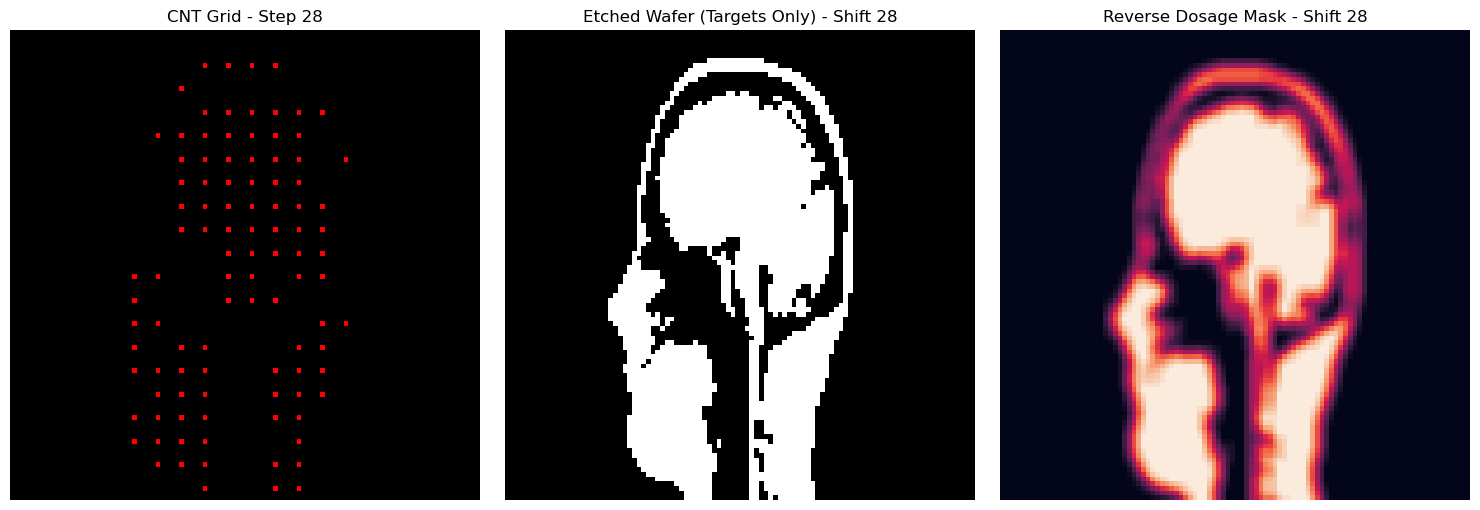

Algorithm completed in 18.55 seconds.
Matches: 100.0%.
There WAS a perfect match.


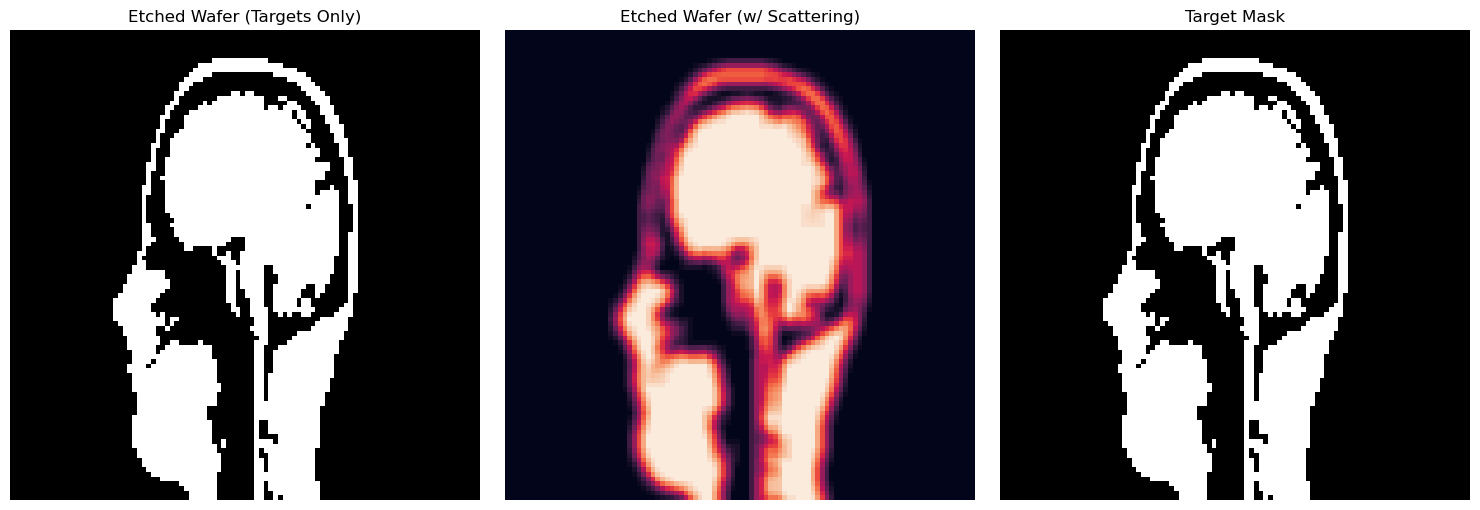

This etching requires 28 shifts.


,Shift,Activated CNT Indices,Relative Dosages
0,STAY,"[127, 192, 285, 171, 73, 231, 148, 291, 368, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,RIGHT,"[371, 190, 273, 169, 211, 71, 327, 387, 146, 3...","[0.9999515, 0.9999515, 0.9999515, 0.9999515, 0..."
2,RIGHT,"[271, 167, 209, 325, 111, 266, 88, 106, 352, 1...","[0.9999008, 0.9999008, 0.99994934, 0.9999008, ..."
3,DOWN,"[311, 371, 130, 350, 68, 148, 190, 86, 306, 32...","[0.9998161, 0.9998161, 0.9998161, 0.9998161, 0..."
4,RIGHT,"[128, 348, 244, 30, 286, 188, 105, 325, 46, 20...","[0.99975497, 0.99993885, 0.9998161, 0.99975497..."
5,DOWN,"[272, 168, 70, 290, 311, 109, 365, 151, 267, 8...","[0.9996398, 0.9996398, 0.9996398, 0.9997752, 0..."
6,DOWN,"[312, 172, 110, 330, 89, 351, 253, 149, 51, 30...","[0.9996301, 0.9996301, 0.9996301, 0.9997043, 0..."
7,RIGHT,"[310, 212, 108, 191, 87, 129, 31, 251, 147, 30...","[0.99970645, 0.99953026, 0.99953026, 0.9995302..."
8,RIGHT,"[210, 287, 189, 127, 347, 166, 68, 324, 184, 1...","[0.99985445, 0.9994923, 0.9995407, 0.9994923, ..."
9,DOWN,"[229, 131, 351, 289, 48, 191, 170, 66, 108, 22...","[0.99984425, 0.9994383, 0.9994383, 0.9999054, ..."


In [4]:
sim = ElectronBeamLithographySimulator(wafer_dim=(100,100), cnt_grid_shape=(20,20), cnt_unit_dim=(5,5), sg_ksize=5, sg_sigma=1, pixel_size_nm=5, wafer_depth=400, psf_kernel_size=5, sigma_forward=5, sigma_backward=10, weight_forward=0.9, weight_backward=0.1, exposure_thresh_low=0.2, exposure_thresh_high=1.2, exposure_target=1.0, sigmoid_steepness=10)
data = sim.run_lithography(display=True, image_file = "sample_masks/brain.png", mask_flip=False)
data


Algorithm completed in 0.7 seconds.
Matches: 100.0%.
There WAS a perfect match.


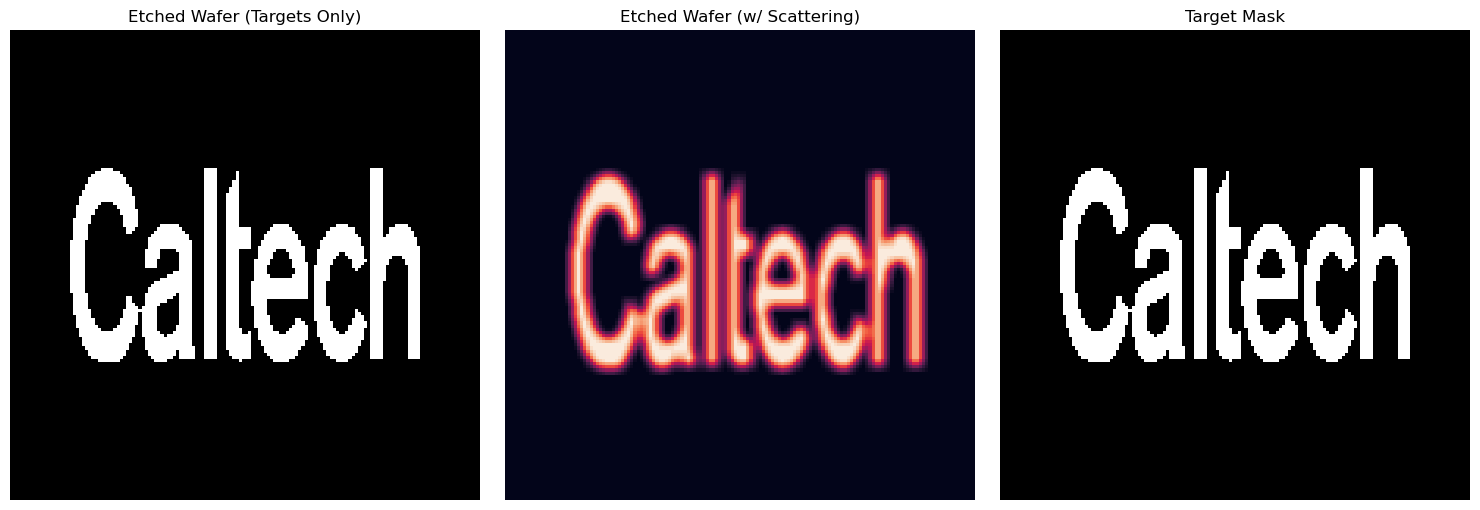

This etching requires 98 shifts.


In [5]:
sim = ElectronBeamLithographySimulator(wafer_dim=(150,150), cnt_grid_shape=(20,20), cnt_unit_dim=(5,5), sg_ksize=5, sg_sigma=1, pixel_size_nm=5, wafer_depth=400, psf_kernel_size=5, sigma_forward=5, sigma_backward=10, weight_forward=0.9, weight_backward=0.1, exposure_thresh_low=0.2, exposure_thresh_high=1.2, exposure_target=1.0, sigmoid_steepness=10)
    
data = sim.run_lithography(display=False, image_file = "sample_masks/caltech.jpg", mask_flip=True)


Algorithm completed in 7.95 seconds.
Matches: 100.0%.
There WAS a perfect match.


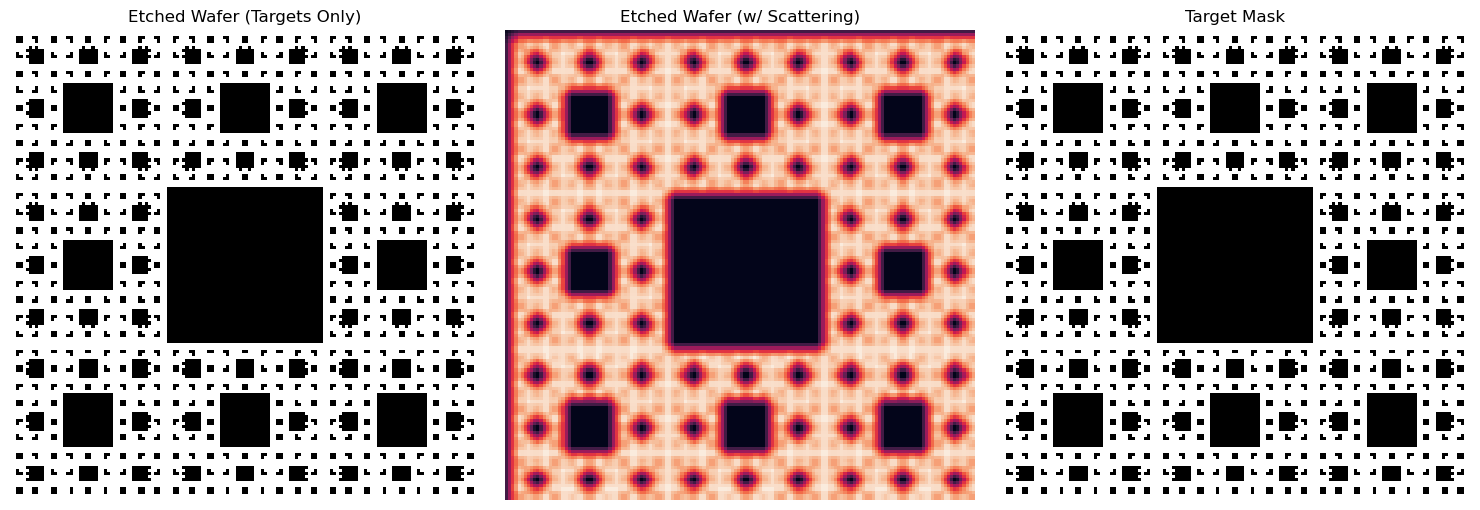

This etching requires 871 shifts.


In [6]:
sim = ElectronBeamLithographySimulator(wafer_dim=(150,150), cnt_grid_shape=(20,20), cnt_unit_dim=(5,5), sg_ksize=5, sg_sigma=1, pixel_size_nm=5, wafer_depth=400, psf_kernel_size=5, sigma_forward=5, sigma_backward=10, weight_forward=0.9, weight_backward=0.1, exposure_thresh_low=0.2, exposure_thresh_high=1.2, exposure_target=1.0, sigmoid_steepness=10)
    
data = sim.run_lithography(display=False, image_file = "sample_masks/fractal.jpg", mask_flip=True)


Algorithm completed in 6.24 seconds.
Matches: 100.0%.
There WAS a perfect match.


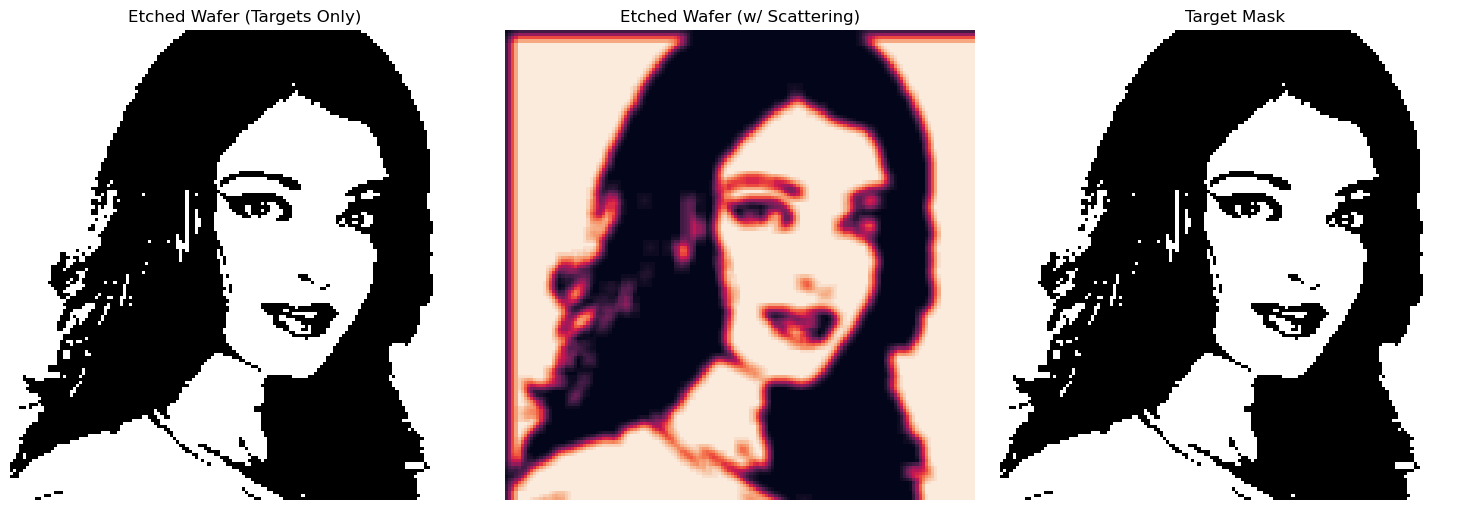

This etching requires 927 shifts.


In [7]:
sim = ElectronBeamLithographySimulator(wafer_dim=(150,150), cnt_grid_shape=(20,20), cnt_unit_dim=(5,5), sg_ksize=5, sg_sigma=1, pixel_size_nm=5, wafer_depth=400, psf_kernel_size=5, sigma_forward=5, sigma_backward=10, weight_forward=0.9, weight_backward=0.1, exposure_thresh_low=0.2, exposure_thresh_high=1.2, exposure_target=1.0, sigmoid_steepness=10)
    
data = sim.run_lithography(display=False, image_file = "sample_masks/woman.jpeg", mask_flip=True)


Algorithm completed in 2.76 seconds.
Matches: 100.0%.
There WAS a perfect match.


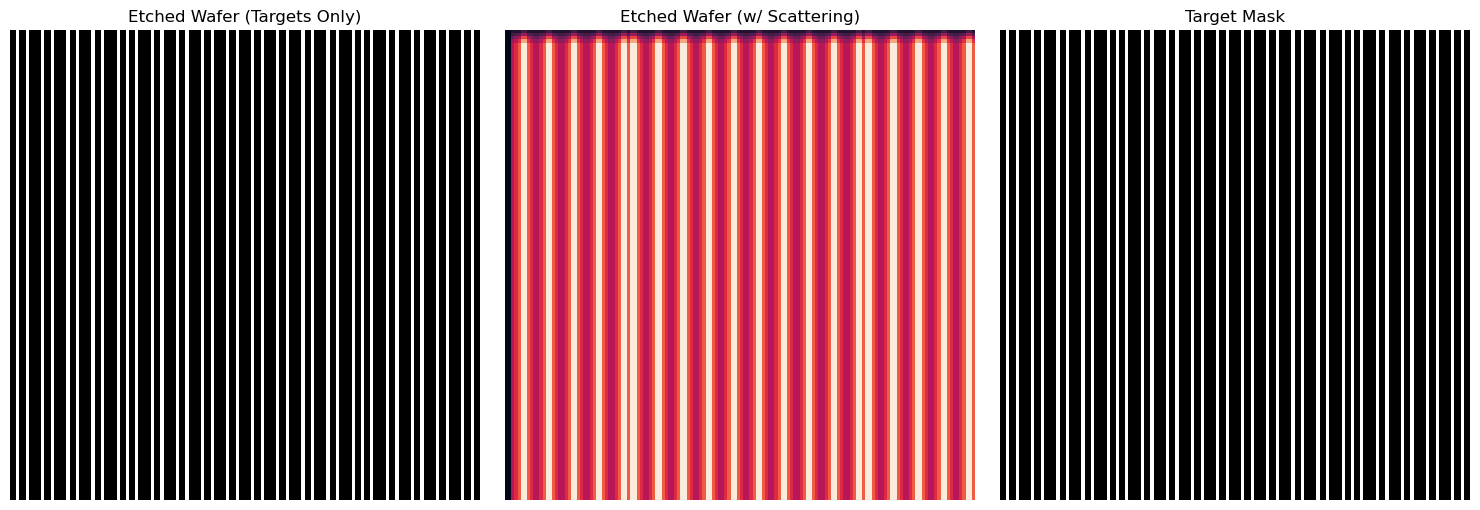

This etching requires 796 shifts.


In [8]:
sim = ElectronBeamLithographySimulator(wafer_dim=(150,150), cnt_grid_shape=(20,20), cnt_unit_dim=(5,5), sg_ksize=5, sg_sigma=1, pixel_size_nm=5, wafer_depth=400, psf_kernel_size=5, sigma_forward=5, sigma_backward=10, weight_forward=0.9, weight_backward=0.1, exposure_thresh_low=0.2, exposure_thresh_high=1.2, exposure_target=1.0, sigmoid_steepness=10)
    
data = sim.run_lithography(display=False, image_file = "sample_masks/lines.jpg", mask_flip=True)
